# ZKsyn data exploration - Fees and gas

#### [Maria Silva](https://github.com/misilva73), June 2024

## Import packages

In [1]:
import os
import polars as pl
import plotly.graph_objects as go

In [2]:
import sys
code_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "src"))

sys.path.append(code_dir)

Note that these are support functions defined in the `src` folder:

In [3]:
from plot_utils import get_plotly_layout, colors

width, height = 800, 450

##  Load Polars DataFrames

In [4]:
# Set directory paths
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
plots_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "plots"))

In [5]:
# Load blocks data
blocks_path = os.path.join(data_dir, "blocks", "blocks_*.parquet")
blocks_lazy_df = (
    pl.scan_parquet(blocks_path)
    .with_columns(pl.from_epoch("timestamp", time_unit="s"))
    .sort("timestamp")
)
blocks_lazy_df.schema

OrderedDict([('hash', String),
             ('parentHash', String),
             ('sha3Uncles', String),
             ('miner', String),
             ('stateRoot', String),
             ('transactionsRoot', String),
             ('receiptsRoot', String),
             ('number', Int64),
             ('l1BatchNumber', String),
             ('gasUsed', Int64),
             ('gasLimit', Int64),
             ('baseFeePerGas', Int64),
             ('extraData', String),
             ('logsBloom', String),
             ('timestamp', Datetime(time_unit='us', time_zone=None)),
             ('l1BatchTimestamp', String),
             ('difficulty', Int64),
             ('totalDifficulty', Int64),
             ('sealFields', List(Null)),
             ('uncles', List(Null)),
             ('size', Int64),
             ('mixHash', String),
             ('nonce', String)])

In [6]:
# Load transaction data
txs_path = os.path.join(data_dir, "transactions", "transactions_*.parquet")
txs_lazy_df = pl.scan_parquet(txs_path)
txs_lazy_df.schema

OrderedDict([('blockHash', String),
             ('blockNumber', Int64),
             ('chainId', Int64),
             ('from', String),
             ('gas', Int64),
             ('gasPrice', Int64),
             ('hash', String),
             ('input', String),
             ('l1BatchNumber', String),
             ('l1BatchTxIndex', String),
             ('maxFeePerGas', Int64),
             ('maxPriorityFeePerGas', Int64),
             ('nonce', Int64),
             ('r', String),
             ('s', String),
             ('to', String),
             ('transactionIndex', Int64),
             ('type', Int64),
             ('v', Float64),
             ('value', String)])

##  Process Polars DataFrames

In [7]:
# Compute daily aggregated data for blocks
block_data_per_day_df = (
    blocks_lazy_df
    .group_by_dynamic("timestamp", every="1d")
    .agg(
        pl.col("gasUsed").mean().alias("avg_gas_used_block"),
        pl.col("gasUsed").sum().alias("total_gas_used_day"),
        pl.col("baseFeePerGas").mean().alias("avg_base_fee_price_block")
    )
    .collect(streaming=True)
    .to_pandas()
    [30:] # Ignoring the first 30 days!
)
block_data_per_day_df.head()

,timestamp,avg_gas_used_block,total_gas_used_day,avg_base_fee_price_block
30,2023-03-15,7.712988e+05,12340780,250000000.0
31,2023-03-16,2.185386e+06,34966175,250000000.0
32,2023-03-17,8.687716e+06,312757768,250000000.0
33,2023-03-18,9.685889e+06,193717779,250000000.0
34,2023-03-19,1.245831e+06,49833221,250000000.0


In [8]:
# Compute daily aggregated data for transactions
temp_blocks_df = (
    blocks_lazy_df
    .select(pl.col("number"), pl.col("timestamp").cast(pl.Date).alias("day"))
)
tx_data_per_day_df = (
    txs_lazy_df
    .join(temp_blocks_df, left_on="blockNumber", right_on="number")
    .sort("day")
    .group_by_dynamic("day", every="1d")
    .agg(
        pl.col("gas").mean().alias("avg_gas_used_tx"),
        pl.col("gas").sum().alias("total_gas_used_day"),
        pl.col("gasPrice").mean().alias("avg_gas_price_tx"),
        pl.col("maxFeePerGas").mean().alias("avg_max_price_tx"),
        pl.col("maxPriorityFeePerGas").mean().alias("avg_max_prio_price_tx")
    )
    .collect(streaming=True)
    .to_pandas()
    [30:] # Ignoring the first 30 days!
)
tx_data_per_day_df.head()

,day,avg_gas_used_tx,total_gas_used_day,avg_gas_price_tx,avg_max_price_tx,avg_max_prio_price_tx
30,2023-03-16,4.344483e+06,39100351,1.666667e+08,5.833333e+08,4.166667e+08
31,2023-03-17,1.305611e+07,365571020,1.875000e+08,4.116964e+08,3.160714e+08
32,2023-03-18,1.736628e+07,243127944,2.321429e+08,8.571429e+08,6.071429e+08
33,2023-03-19,3.484732e+06,114996140,2.348485e+08,5.909091e+08,4.848485e+08
34,2023-03-20,2.674540e+07,1203543147,2.166667e+08,4.244444e+08,3.477778e+08


## Gas usage analysis

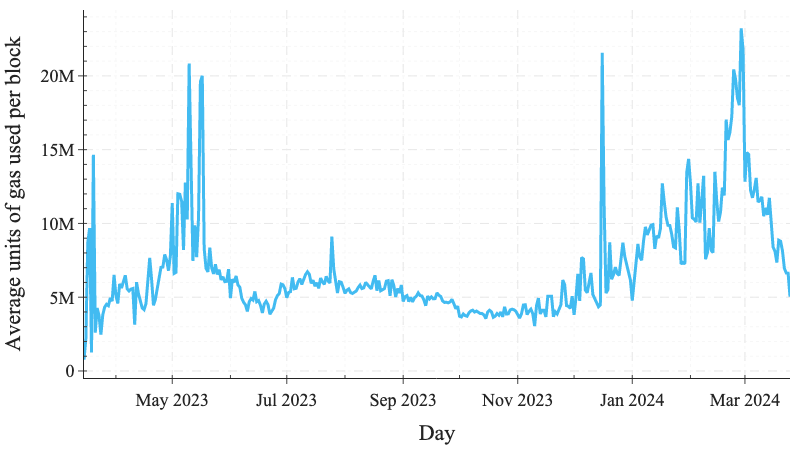

In [9]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=block_data_per_day_df['timestamp'], 
    y=block_data_per_day_df['avg_gas_used_block'], 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(yaxis_title="Average units of gas used per block",
                  xaxis_title="Day", legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'avg-gas-used-block.pdf'))
fig.show('png')

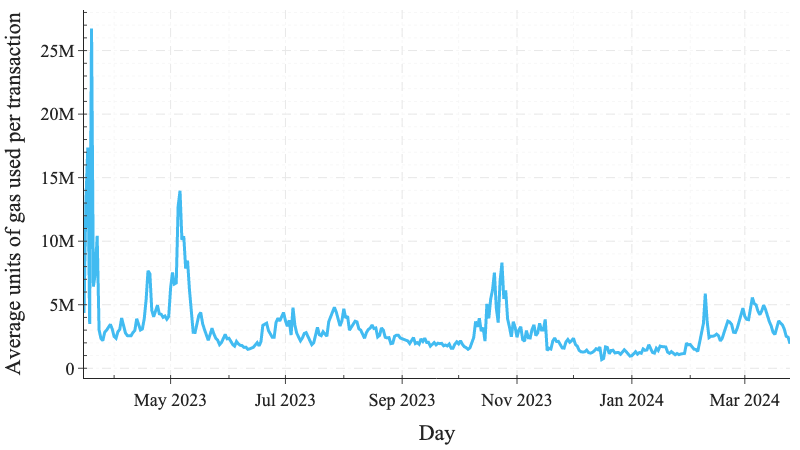

In [10]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=tx_data_per_day_df['day'], 
    y=tx_data_per_day_df['avg_gas_used_tx'], 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(yaxis_title="Average units of gas used per transaction",
                  xaxis_title="Day", legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'avg-gas-used-tx.pdf'))
fig.show('png')

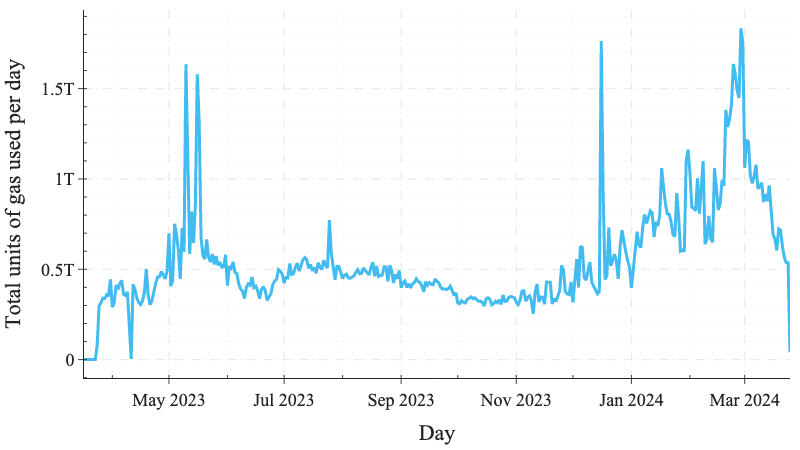

In [11]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=block_data_per_day_df.iloc[2:]['timestamp'], 
    y=block_data_per_day_df.iloc[2:]['total_gas_used_day'], 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(yaxis_title="Total units of gas used per day",
                  xaxis_title="Day", legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'daily-total-gas-used-v1.pdf'))
fig.show('png')

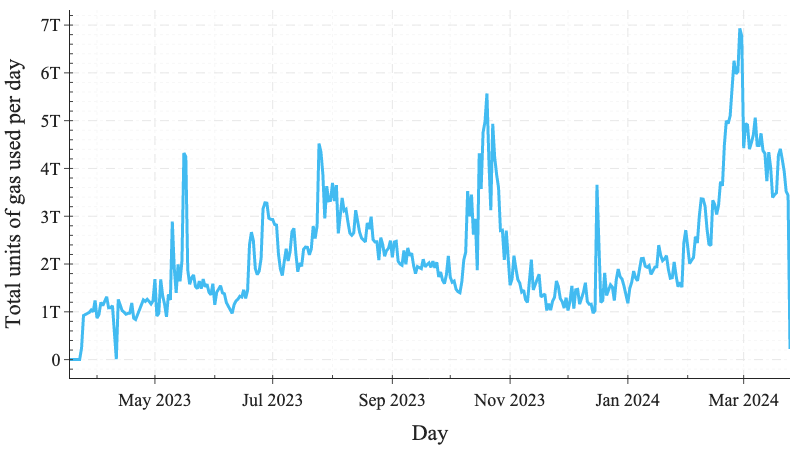

In [12]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=tx_data_per_day_df.iloc[2:]['day'], 
    y=tx_data_per_day_df.iloc[2:]['total_gas_used_day'], 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(yaxis_title="Total units of gas used per day",
                  xaxis_title="Day", legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'daily-total-gas-used-v2.pdf'))
fig.show('png')